In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
df1 = pd.read_csv("../Data/Blood/Blood_samples_dataset_balanced.csv")
df2 = pd.read_csv("../Data/Blood/blood_samples_dataset_test.csv")

df = pd.concat([df1, df2], ignore_index=True)

df["Disease"] = df["Disease"].astype('category')

In [4]:
df["Disease"].cat.categories
labels = ['Anemia', 'Diabetes', 'Healthy', 'Heart Di', 'Thalasse', 'Thromboc']
# df["Disease"].cat.codes
df.head()

,Glucose,Cholesterol,Hemoglobin,Platelets,White Blood Cells,Red Blood Cells,Hematocrit,Mean Corpuscular Volume,Mean Corpuscular Hemoglobin,Mean Corpuscular Hemoglobin Concentration,...,HbA1c,LDL Cholesterol,HDL Cholesterol,ALT,AST,Heart Rate,Creatinine,Troponin,C-reactive Protein,Disease
0,0.739597,0.650198,0.713631,0.868491,0.687433,0.529895,0.290006,0.631045,0.001328,0.795829,...,0.502665,0.215560,0.512941,0.064187,0.610827,0.939485,0.095512,0.465957,0.769230,Healthy
1,0.121786,0.023058,0.944893,0.905372,0.507711,0.403033,0.164216,0.307553,0.207938,0.505562,...,0.856810,0.652465,0.106961,0.942549,0.344261,0.666368,0.659060,0.816982,0.401166,Diabetes
2,0.452539,0.116135,0.544560,0.400640,0.294538,0.382021,0.625267,0.295122,0.868369,0.026808,...,0.466795,0.387332,0.421763,0.007186,0.506918,0.431704,0.417295,0.799074,0.779208,Thalasse
3,0.136609,0.015605,0.419957,0.191487,0.081168,0.166214,0.073293,0.668719,0.125447,0.501051,...,0.016256,0.040137,0.826721,0.265415,0.594148,0.225756,0.490349,0.637061,0.354094,Anemia
4,0.176737,0.752220,0.971779,0.785286,0.443880,0.439851,0.894991,0.442159,0.257288,0.805987,...,0.429431,0.146294,0.221574,0.015280,0.567115,0.841412,0.153350,0.794008,0.094970,Thalasse


In [5]:
X = df.drop('Disease',axis=1).values
y = df['Disease'].cat.codes.values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)


In [6]:
class Model(nn.Module):
    def __init__(self, in_features=24, h1=48, h2=49, out_features=6):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x


In [7]:
torch.manual_seed(40)
model = Model()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
epochs = 200
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # a neat trick to save screen space:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 1.80620575
epoch: 11  loss: 1.47229767
epoch: 21  loss: 1.11553097
epoch: 31  loss: 0.81265330
epoch: 41  loss: 0.61591053
epoch: 51  loss: 0.45621490
epoch: 61  loss: 0.35219157
epoch: 71  loss: 0.28466934
epoch: 81  loss: 0.23657213
epoch: 91  loss: 0.19958502
epoch: 101  loss: 0.16901813
epoch: 111  loss: 0.14349373
epoch: 121  loss: 0.12191542
epoch: 131  loss: 0.10756277
epoch: 141  loss: 0.09090372
epoch: 151  loss: 0.07722300
epoch: 161  loss: 0.06666826
epoch: 171  loss: 0.05785196
epoch: 181  loss: 0.05035255
epoch: 191  loss: 0.04369520


Text(0.5, 0, 'epoch')

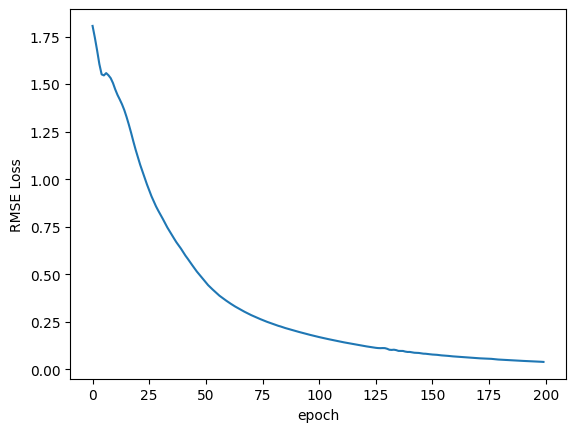

In [9]:
losses_np = [loss.detach().numpy() for loss in losses]
plt.plot(range(epochs), losses_np)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

In [10]:
with torch.no_grad():
    y_val = model(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.29608551


In [11]:
correct = 0
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model(data)
        print(f'{i+1:2}. {str(y_val):38}  {labels[y_test[i]]}  {labels[y_val.argmax().item()]}')
        if y_val.argmax().item() == y_test[i]:
            correct += 1
print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')

 1. tensor([ 2.0810,  6.9986, -0.6610,  2.2592, -3.9057, -3.3642])  Diabetes  Diabetes
 2. tensor([10.4897,  5.0287, -8.7423,  1.0103,  0.8139, -1.6003])  Anemia  Anemia
 3. tensor([  6.1301,  11.7481, -15.6016,   5.7614,   7.0929,  -1.1721])  Diabetes  Diabetes
 4. tensor([ 8.1956, 13.6291, -8.9833,  8.0115,  0.6885, -7.8488])  Diabetes  Diabetes
 5. tensor([ -0.4157,   5.2421,  11.6995,   6.9545,   0.3616, -14.2501])  Diabetes  Healthy
 6. tensor([-1.7351, -1.8508, 11.1481,  1.4579,  1.8445, -7.9185])  Healthy  Healthy
 7. tensor([  7.0370,  18.8727, -17.3130,   3.1775,  -4.0813,   1.0951])  Diabetes  Diabetes
 8. tensor([  6.0835,   6.5454,  -1.2907,   7.2875,  12.8372, -13.8020])  Diabetes  Thalasse
 9. tensor([ 10.3847,  15.1363, -23.3873,   6.4435,   3.5411,   2.5067])  Diabetes  Diabetes
10. tensor([-10.9905,   2.7205,  -7.3324,   2.0549,   2.1259,  11.4184])  Thromboc  Thromboc
11. tensor([-10.7987,   1.4423,   8.8303,   3.7931,   1.1339,  -2.2941])  Healthy  Healthy
12. tensor

In [12]:
import pickle
model_filename = "blood_pca_trained_model.pkl"
with open(model_filename, 'wb') as file:
    pickle.dump(model, file)